<a href="https://colab.research.google.com/github/dineshRaja29/LogisticRegression/blob/main/LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<font color='green'><b>INTRODUCTION </b></font>

Applying Logistic Regression on Amazon fine food reviews dataset with various text encoding techinques

##<font color='green'><b>DATASET DETAILS</b></font>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


Note: We could use Score/Rating. A rating of 4 or 5 can be considered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered neutral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.





The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using SQLite Table to read data.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from PIL import Image

con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# using SQLite Table to read data.

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

##<font color='green'><b>Data Cleaning</b></font>

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

##<font color='green'><b>Preprocessing



Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2577.95it/s]


In [ ]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable

In [ ]:
# Confusion matrix print function 
def ConfusionMatrixPrint(cm):
  class_label = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
  sns.heatmap(df_cm, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
  
def ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr):
  plt.figure()
  plt.plot(fpr, tpr,label='Test ROC curve' ,
           color='darkorange', linestyle=':', linewidth=4)

  plt.plot(fpr_tr, tpr_tr,label='Train ROC curve',
           color='navy', linestyle=':', linewidth=4)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE ')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
X = preprocessed_reviews
y = final['Score']
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
print("---------------------------------------------")
print(C)
print("---------------------------------------------")

---------------------------------------------
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
---------------------------------------------


##<font color='green'><b>Logistic Regression with text Encoding as 'BOW'

###<font color='green'><b>With L1 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l1')
  vectorizer =  CountVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)

[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


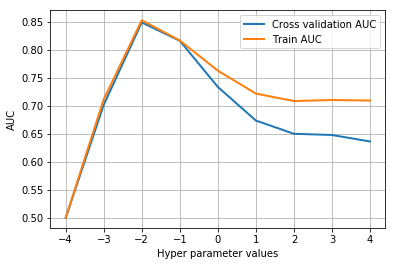

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

In [ ]:
print("------- Optimal Hyperparameter is 0.1------------------")

------- Optimal Hyperparameter is 0.1------------------


In [ ]:
clf = LogisticRegression(C = 0.1, penalty ='l1')
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
clf.fit(X_tr_bow, y_tr)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



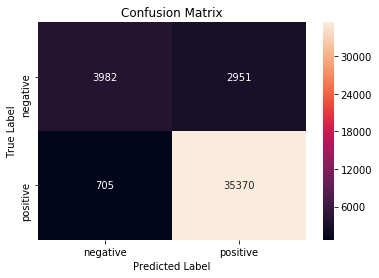

Confusion Matrix on Test 



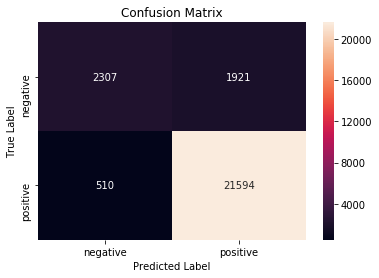

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8010722768876878
**** TRAIN AUC *****  0.8172011908056911


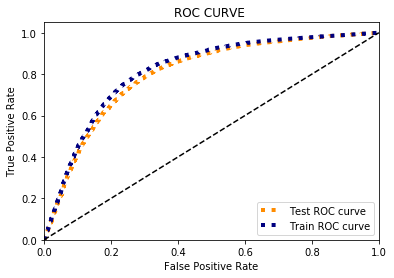

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Sparsity

In [ ]:
sparsityL1 = []
sparsityL2 = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l1')
  vectorizer =  CountVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  w = clf.coef_
  sparsityL1.append(np.count_nonzero(w))
  
  clf = LogisticRegression(C = c, penalty ='l2')
  clf.fit(X_tr_bow,y_tr)
  w = clf.coef_
  sparsityL2.append(np.count_nonzero(w))

In [ ]:
x = PrettyTable()
x.add_column("L1",sparsityL1)
x.add_column("L2",sparsityL2)
print(x)

+-------+-------+
|   L1  |   L2  |
+-------+-------+
|   0   | 39168 |
|   3   | 39168 |
|   88  | 39168 |
|  707  | 39168 |
|  3706 | 39168 |
|  7068 | 39168 |
|  8045 | 39168 |
| 12615 | 39168 |
| 17213 | 39168 |
+-------+-------+


#### As the lambda increases then the sparisty increases, here 'C' is the inverse of lambda that means as we increase 'C' then inherently we are decreasing the lambda. <br>
#### Thus, as the 'C' increases the sparisty decrease due to which the non zero values in the weight vector increases. <br>
#### Justification can be found on the above table.

###<font color='green'><b>With L2 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l2')
  vectorizer =  CountVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  

[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


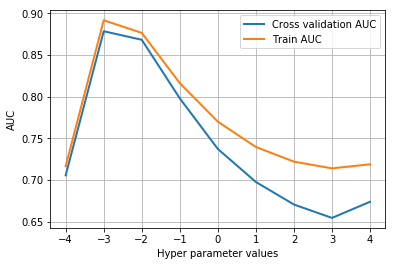

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

In [ ]:
print("------- Optimal Hyperparameter is 0.01 ------------------")

------- Optimal Hyperparameter is 0.01 ------------------


In [ ]:
clf = LogisticRegression(C = 0.01, penalty ='l2')
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
clf.fit(X_tr_bow, y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



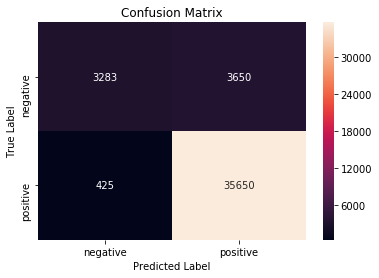

Confusion Matrix on Test 



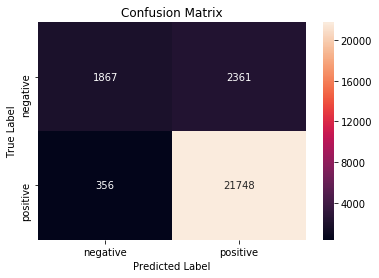

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8570088899435061
**** TRAIN AUC *****  0.8765215143579488


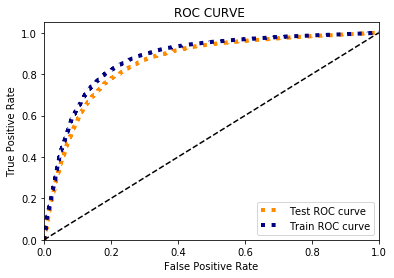

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Feature Importance

Top 10 important features of positive class and Negative 

In [ ]:
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10+ 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
  print ("\t%.4f\t%-15s\t\t%.4f\t%-15s"% (coef_1, fn_1, coef_2, fn_2))

	-0.7522	disappointed   		0.9240	great          
	-0.6692	money          		0.8348	delicious      
	-0.6300	worst          		0.7818	best           
	-0.5983	awful          		0.7202	perfect        
	-0.5763	horrible       		0.6696	excellent      
	-0.5541	unfortunately  		0.6486	loves          
	-0.5312	terrible       		0.6005	wonderful      
	-0.5296	disappointing  		0.5849	nice           
	-0.4905	stale          		0.5460	love           
	-0.4785	waste          		0.5384	highly         


###<font color='green'><b>Pertubation test (multicollinearity check)

<li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_tr)
clf = LogisticRegression(C = 0.1, penalty ='l2')
clf.fit(X, y_tr)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
W = clf.coef_[0]

In [ ]:
mu, sigma = 0, 0.1 
noise = np.random.normal(mu, sigma) 
X.data = X.data + noise

In [ ]:
clf = LogisticRegression(C = 0.1, penalty ='l2')
clf.fit(X, y_tr)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
W_with_noise_in_data = clf.coef_[0] 

In [ ]:
W_with_noise_in_data = np.array(W_with_noise_in_data)
W = np.array(W)

In [ ]:
W = W + 10**-6
W_with_noise_in_data = W_with_noise_in_data + 10**-6

In [ ]:
delta = abs((W - W_with_noise_in_data)/W)*100

In [ ]:
feature_names = vectorizer.get_feature_names()
delta_sorted = sorted(zip(delta, feature_names), reverse = True)

We are plotting the first 300 entries to find the steepness of curve

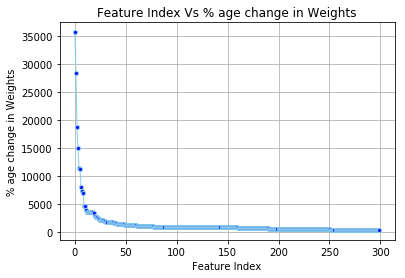

In [ ]:
y, featurename = zip(*delta_sorted)
plt.plot(y[:300], marker='o', markerfacecolor='blue', markersize=4, color='skyblue', linewidth=1)
plt.axis('tight')
plt.grid()
plt.xlabel('Feature Index')
plt.ylabel('% age change in Weights')
plt.title('Feature Index Vs % age change in Weights')
plt.show()

We select '50' as threshold, to conclude that first 50 features are multicollinear

In [ ]:
print("---- Multi-Collinear Features are ---------")
for f in featurename[:51]:
  print(f)

---- Multi-Collinear Features are ---------
surfing
busted
observed
rices
rests
acted
maker
video
fought
tract
constantly
laced
unwinding
streusel
salong
lani
kei
fairmontstore
dined
daiquiri
curbed
eliminate
hidden
cummunity
sacrificing
chihuahuas
reminiscent
jaw
unsafe
certificate
sam
votes
gums
stateside
insects
sorbate
scrubbing
evaluated
misguided
chains
postage
cases
diligent
tignor
bob
micklegal
boson
injectable
catty
extrememly
smelly


##<font color='green'><b>Logistic Regression with text Encoding as 'TF-IDF'

###<font color='green'><b>With L1 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l1')
  vectorizer =  TfidfVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  

[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


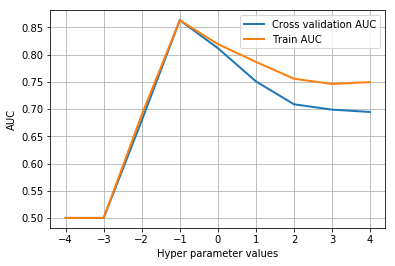

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

In [ ]:
print("------- Optimal Hyperparameter is 0.1------------------")

------- Optimal Hyperparameter is 0.1------------------


In [ ]:
clf = LogisticRegression(C = 0.1, penalty ='l1')
vectorizer =  TfidfVectorizer()
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
clf.fit(X_tr_bow, y_tr)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



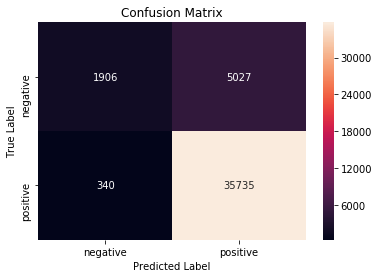

Confusion Matrix on Test 



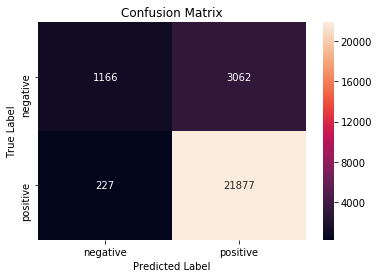

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8566416625235278
**** TRAIN AUC *****  0.8633228368667571


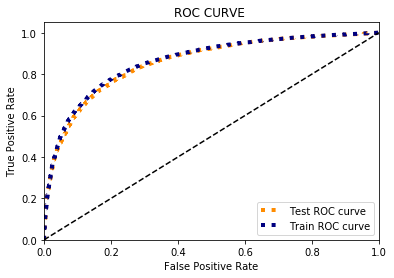

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>With L2 regularization

In [ ]:
# Please write all the code with proper documentation
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l2')
  vectorizer =  TfidfVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  

[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


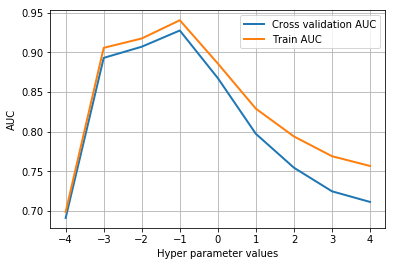

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

In [ ]:
print("------- Optimal Hyperparameter is 0.1------------------")

------- Optimal Hyperparameter is 0.1------------------


In [ ]:
clf = LogisticRegression(C = 0.1, penalty ='l2')
vectorizer =  TfidfVectorizer()
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
clf.fit(X_tr_bow, y_tr)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



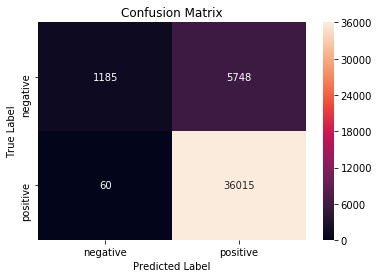

Confusion Matrix on Test 



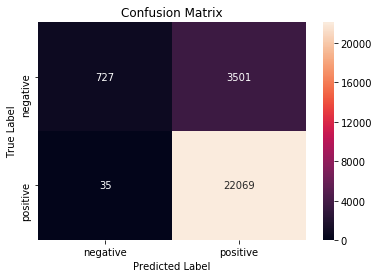

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.9278911063242448
**** TRAIN AUC *****  0.9402612051854802


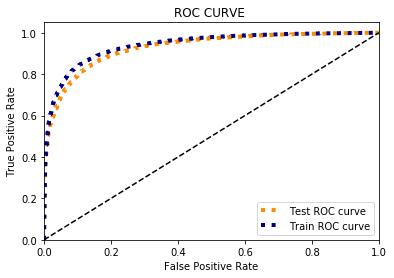

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Feature Importance

Top 10 important features of positive class and Negative

In [ ]:
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10+ 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
  print ("\t%.4f\t%-15s\t\t%.4f\t%-15s"% (coef_1, fn_1, coef_2, fn_2))

	-5.0301	not            		4.7950	great          
	-2.6292	disappointed   		3.0897	best           
	-2.4317	money          		3.0822	love           
	-2.3916	bad            		2.8754	good           
	-2.0014	worst          		2.6681	delicious      
	-1.9517	awful          		2.1467	loves          
	-1.9077	horrible       		2.1349	perfect        
	-1.8743	away           		2.0306	nice           
	-1.7921	waste          		1.8076	excellent      
	-1.7879	terrible       		1.7674	favorite       


##<font color='green'><b>Logistic Regression with text Encoding as 'AVG W2V'

In [ ]:
# Please write all the code with proper documentation
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
X_tr_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in (training_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_vectors.append(sent_vec)


In [ ]:
cv_words = []
for sentance in X_cv:
    cv_words.append(sentance.split())

X_cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in cv_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)


In [ ]:
test_words = []
for sentance in X_test:
    test_words.append(sentance.split())

X_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in test_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

###<font color='green'><b>With L1 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l1')
  clf.fit(X_tr_vectors,y_tr)
  y_cv_predict = np.array(clf.predict_proba(X_cv_vectors))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC) 


[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


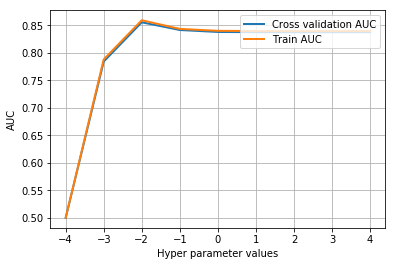

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

Optimal Hyperparameter is C = 0.1

In [ ]:
clf = LogisticRegression(C = 0.1, penalty ='l1')
clf.fit(X_tr_vectors, y_tr)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



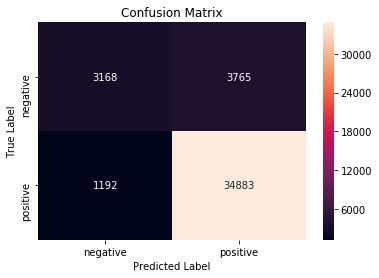

Confusion Matrix on Test 



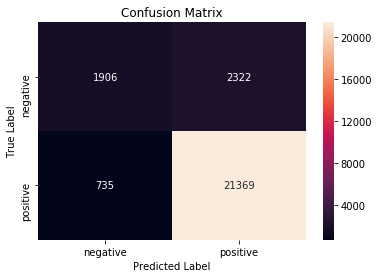

In [ ]:
predict = clf.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.839059628586426
**** TRAIN AUC *****  0.8433877848157381


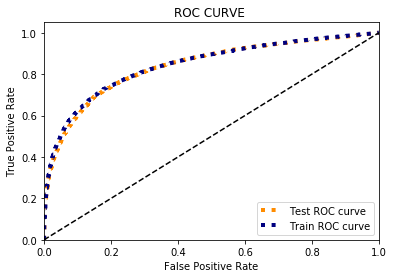

In [ ]:
y_cv_predict = np.array(clf.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>With L2 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l2')
  clf.fit(X_tr_vectors,y_tr)
  y_cv_predict = np.array(clf.predict_proba(X_cv_vectors))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  


[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


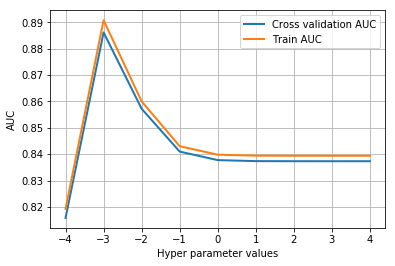

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

Optimal Hyperparameter is C = 0.01

In [ ]:
clf = LogisticRegression(C = 0.01 , penalty ='l2')
clf.fit(X_tr_vectors, y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



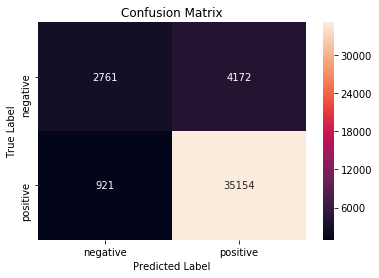

Confusion Matrix on Test 



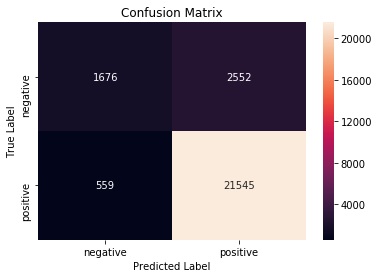

In [ ]:
predict = clf.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8559271476097684
**** TRAIN AUC *****  0.859980330495259


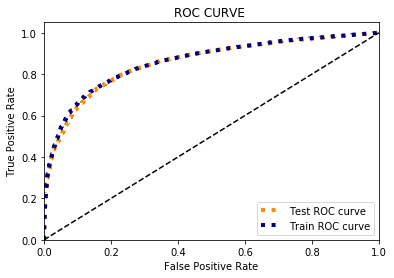

In [ ]:
y_cv_predict = np.array(clf.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>Logistic Regression with text Encoding as 'TFIDF W2V'

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [ ]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names

In [ ]:
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 43008/43008 [17:21<00:00, 41.31it/s]


In [ ]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 18433/18433 [07:19<00:00, 41.90it/s]


In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [10:23<00:00, 42.25it/s]


###<font color='green'><b>With L1 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l1')
  clf.fit(tfidf_sent_vectors_tr,y_tr)
  y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_cv))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC) 


[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


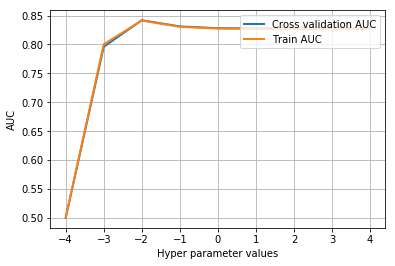

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

Optimal Hyperparameter is C = 0.01

In [ ]:
clf = LogisticRegression(C = 0.01, penalty ='l1')
clf.fit(tfidf_sent_vectors_tr, y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



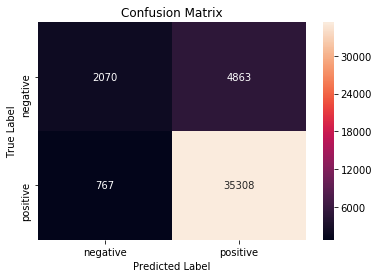

Confusion Matrix on Test 



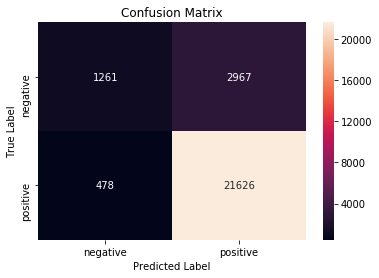

In [ ]:
predict = clf.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8412246647909547
**** TRAIN AUC *****  0.8412993148259267


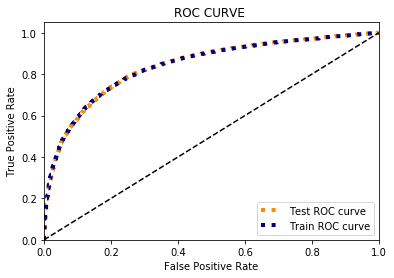

In [ ]:
y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>With L2 regularization

In [ ]:
cv_auc = []
train_auc = []
iterator = []
for c in C:
  clf = LogisticRegression(C = c, penalty ='l2')
  clf.fit(tfidf_sent_vectors_tr,y_tr)
  y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_cv))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC) 


[-4. -3. -2. -1.  0.  1.  2.  3.  4.]


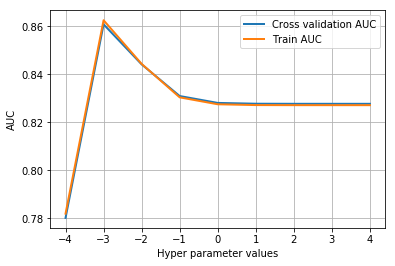

In [ ]:
#plotting the graph 
iterator = np.log10(C)
print(iterator)
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

Optimal Hyperparameter is C = 0.01

In [ ]:
clf = LogisticRegression(C = 0.01, penalty ='l2')
clf.fit(tfidf_sent_vectors_tr, y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix on Train 



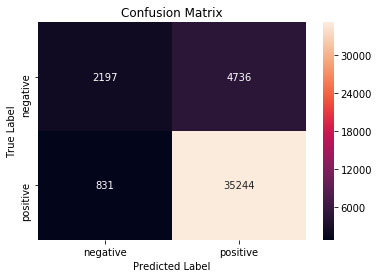

Confusion Matrix on Test 



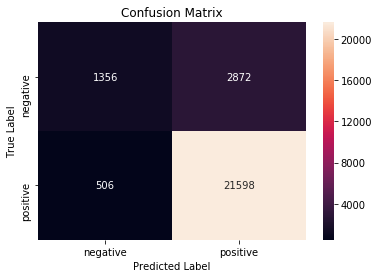

In [ ]:
predict = clf.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8426371199226431
**** TRAIN AUC *****  0.844331333297149


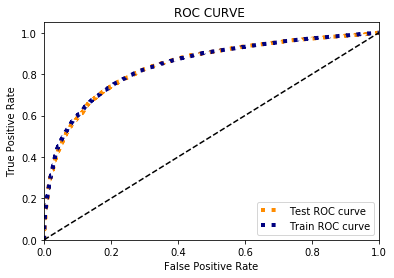

In [ ]:
y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>RESULTS

In [ ]:
x = PrettyTable()
x.add_column("S.No",[1,2,3,4,5,6,7,8])
x.add_column("Model Description",["BoW L1", "BoW L2", "TF-IDF L1", "TF-IDF L2", \
                                  "Avg W2Vec L1", "Avg W2Vec L2", "TF-IDF W2Vec L1",\
                                  "TF-IDF W2Vec L2"])
x.add_column("Hyper-parameter value",[0.1,0.01,0.1,0.1,0.1,0.01,0.01,0.01])
x.add_column("Test AUC",[0.801,0.857,0.856,0.927,0.839,0.855,0.841,0.842])
print(x)

+------+-------------------+-----------------------+----------+
| S.No | Model Description | Hyper-parameter value | Test AUC |
+------+-------------------+-----------------------+----------+
|  1   |       BoW L1      |          0.1          |  0.801   |
|  2   |       BoW L2      |          0.01         |  0.857   |
|  3   |     TF-IDF L1     |          0.1          |  0.856   |
|  4   |     TF-IDF L2     |          0.1          |  0.927   |
|  5   |    Avg W2Vec L1   |          0.1          |  0.839   |
|  6   |    Avg W2Vec L2   |          0.01         |  0.855   |
|  7   |  TF-IDF W2Vec L1  |          0.01         |  0.841   |
|  8   |  TF-IDF W2Vec L2  |          0.01         |  0.842   |
+------+-------------------+-----------------------+----------+
